In [101]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx 

In [102]:
dataset = MiniGCDataset(80,10,20)


In [103]:
#check how the dataset looks like 
#dataset[5:10]

Text(0.5, 1.0, 'Class :0')

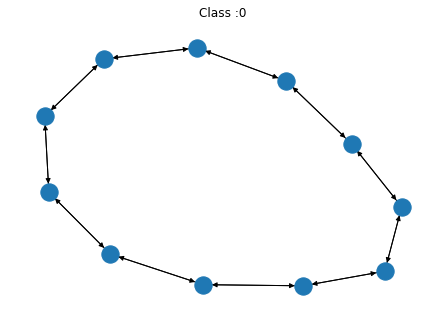

In [104]:
graph, label = dataset[0]
nx.draw(graph.to_networkx())
plt.title(f'Class :{label}')

In [105]:
import torch
import dgl
def collate(samples):
    #print(f"samples datatype{type(samples)}")
    graphs, labels = map(list, zip(*samples))
    #print(f"graphs and lables after map{graphs,labels},type{graphs}")
    batched_graph =dgl.batch(graphs)
    
    return batched_graph,torch.tensor(labels)


In [106]:
# test how mini batch forms: 
#test_sam = MiniGCDataset(5,10,20)

#collate(test_sam)

# summery : it adds all the nodes and edges


In [107]:
# how in_degrees works 
# g_test = test_sam[1][0]
#print(g_test.in_degrees(),g_test) 

In [108]:
from dgl.nn.pytorch import GraphConv

In [109]:
# aagregation and classification 

import torch.nn as nn
import torch.nn.functional as F 

class Classifier(nn.Module):
    def __init__(self,in_dim,hidden_dim,n_classes):
        super(Classifier,self).__init__()
        self.conv1 = GraphConv(in_dim,hidden_dim)
        self.conv2 = GraphConv(hidden_dim,hidden_dim)
        self.classify = nn.Linear(hidden_dim,n_classes)

    def forward(self,g): 
        h =g.in_degrees().view(-1,1).float()
        #print(f"starting h{h},{h.shape}")
        h = F.relu(self.conv1(g,h))
        h = F.relu(self.conv2(g,h))
        g.ndata['h']=h

        hg = dgl.mean_nodes(g,'h')
        #print(f"after mean{h},{h.shape}")
        hg = self.classify(hg)
        #print(f"hg size {hg.shape},hg {hg}")
        return hg
        
        

In [110]:
import torch.optim as optim
from torch.utils.data import DataLoader

trainset = MiniGCDataset(320,10,20)
testset = MiniGCDataset(80,10,20)

data_loader = DataLoader(trainset,batch_size=32, shuffle= True , collate_fn= collate)


model = Classifier(1,256,trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
model.train()
epochs = 80

losses = []

for epoch in range(epochs):
    
    for iter, (bg,label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print('Epoch {}, loss {:.4f}'.format(epoch, loss.item()))



Epoch 0, loss 2.0840
Epoch 1, loss 2.1068
Epoch 2, loss 2.0147
Epoch 3, loss 1.9495
Epoch 4, loss 1.9838
Epoch 5, loss 1.8222
Epoch 6, loss 1.9310
Epoch 7, loss 1.7532
Epoch 8, loss 1.7789
Epoch 9, loss 1.8145
Epoch 10, loss 1.6110
Epoch 11, loss 1.6531
Epoch 12, loss 1.6839
Epoch 13, loss 1.7314
Epoch 14, loss 1.4526
Epoch 15, loss 1.4604
Epoch 16, loss 1.4847
Epoch 17, loss 1.1376
Epoch 18, loss 1.3174
Epoch 19, loss 1.3516
Epoch 20, loss 1.3967
Epoch 21, loss 1.1868
Epoch 22, loss 1.0547
Epoch 23, loss 1.0689
Epoch 24, loss 1.1185
Epoch 25, loss 1.0479
Epoch 26, loss 1.2914
Epoch 27, loss 0.9242
Epoch 28, loss 0.9557
Epoch 29, loss 1.0417
Epoch 30, loss 1.2136
Epoch 31, loss 0.9454
Epoch 32, loss 0.8672
Epoch 33, loss 0.9351
Epoch 34, loss 0.8948
Epoch 35, loss 0.9982
Epoch 36, loss 0.9323
Epoch 37, loss 0.7331
Epoch 38, loss 0.8540
Epoch 39, loss 0.9941
Epoch 40, loss 0.9074
Epoch 41, loss 0.9278
Epoch 42, loss 1.1306
Epoch 43, loss 0.7194
Epoch 44, loss 0.8047
Epoch 45, loss 0.885

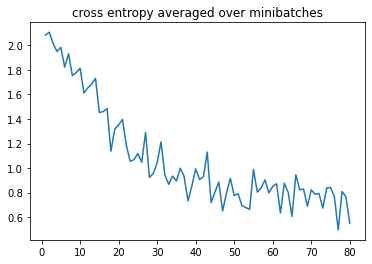

In [111]:
plt.title('cross entropy averaged over minibatches')
plt.plot(range(1,epochs+1),losses)


In [112]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 55.0000%
Accuracy of argmax predictions on the test set: 73.750000%
